# Does building new lightrail change ridership on Bus and Light Rail in the same transit system?
---



Video Link: https://drive.google.com/file/d/1ioFXawasKqv9GZKZW9SVc9mK4zSP9wRh/view?usp=sharing

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ X ] YES - make available
* [  ] NO - keep private

# Overview

We attempted to find a relationship between the opening of new transit projects and change in ridership in those transit systems. Ultimately, with the data available, we were only able to look at the opening of new light rail systems. We were unable to tease out a significant relationship between the opening of new portions of light rail systems and ridership on those systems' light rail and bus network. This could be due to the lack of a real relationship or due to our methodology. 

# Names

- Alfonso Alfonso
- Bobby Baylon
- Mingjin Zhang
- Hang Liu
- Nathaniel Mackler

<a id='research_question'></a>
# Research Question

San Diego MTS made major expansions to the San Diego Trolley system in 1997 with the Mission Valley extension and 2005 with the Mission Valley East extension. Our research question is how the modeshare of San Diego transit usage changed following these upgrades. Specifically, did the bus ridership grow more slowly following these extensions than it had prior to these extensions? Building upon this research, which seeks to replicate prior research, we want to see what the relationships are between other transit modes. For example, did the introduction of MTS Premium Express service (now Rapid Express) increase ridership on local buses due to connections? Did the introduction of the cheaper but slower 235 rapid cannibalize the Rapid Express's ridership? Finally, we'll investigate if the introduction of the coaster increased ridership on local bus and trolley service in the MTS system.

<a id='background'></a>

## Background & Prior Work

One major goal of governments when implementing a new transit system is to change transport mode from private cars to public transit. Mode shifts from cars to transit are especially important because they represent a decrease both in road congestion, (and therefore, hopefully, travel time) as well as the enormous environmental impacts, both in terms of GHGs and other pollutants from exhaust, tires, and brakes. ^1 However, prior research has shown that light rail can often result in trips shifting from buses to light rail rather than cars to light rail.^2 While this is still a social good because it can reduce travel time and increase reliability for those transit riders, it does not result in the same congestion or environmental benefits as mode shifts from private cars.

Unfortunately, the American Community Survey, a product of the census which contains data on mode-share of commutes, does not go back far enough to investigate some of the transit projects we wish to study. Therefore, we will attempt to evaluate the effect of transit systems on the network as a whole by investigating relative growth rates of different parts of the system.



# Hypothesis


We predict that the introduction of new transit systems will have measuerable effects on the rate of growth and absolute number of Unlinked Passenger Trips (UPTs) of multiple different modes of transit. While it is possible for the direction of these changes to be positive or negative, we specifically predict that the opening of new light rail segments will increase UPTs on Motor Buses, and that the introduction of new Commuter buses may increase the ridership on Motor Buses and Light Rail. Finally, we predict that the introduction of the commuter/motor hybrid Route 235 (which is counted in the data as a Motor Bus) will negatively impact ridership on the Commuter Bus lines that duplicate the route. Some reasons that we have to support our hypothesis is that people using Commuter buses to get to downtown San Diego will then need to connect to a motor bus or light rail to get to their final definition. And opening a new trolley line will lead to more people using transit, and those people will then be more likely to ride buses, either due to increased familiarity with the system or a need to transfer.

# Dataset(s)

 Dataset Name: NTD Time Series 2021 TS2.1 Service Data and Operating Expenses Time Series by Mode
- Link to the dataset: https://www.transit.dot.gov/sites/fta.dot.gov/files/2021-Annual-Time-Series.zip 
- Number of observations: ~400

This dataset provides public transit data reported by public transit operators who receive federal funding. This covers multiple data points such as Passenger Miles Traveled, Operating Expenses. We will primarily be focusing on Unlinked Passenger Trips and Vehicle Revenue Hours

* Dataset Name: Resident Population in San Diego County, CA
*   Link to the dataset: https://fred.stlouisfed.org/series/CASAND5POP
*   Number of observations: 52
This dataset shows the population of San Diego County from the years 1970 to 2021.

(Similar data also retrieved for Portland and Sacramento metro areas after scope change)

While our main focus lies in the NTD, we need this dataset of the population of San Diego as it is a confounding variable that we need to account for when analyzing the data of passengers.

# Setup

In [ ]:
!pip install xlrd==1.2.0
import xlrd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
NTD = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/c6fea8074ba77a7974cb0e574bd9adf89bc8ccac/TS2.1%20Service%20Data%20and%20Operating%20Expenses%20Time%20Series%20by%20Mode.xlsx?raw=true', sheet_name='UPT', engine='openpyxl')
NTD_VRH = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/c6fea8074ba77a7974cb0e574bd9adf89bc8ccac/TS2.1%20Service%20Data%20and%20Operating%20Expenses%20Time%20Series%20by%20Mode.xlsx?raw=true', sheet_name='VRH', engine='openpyxl')


/usr/local/lib/python3.8/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [ ]:
fred_SD = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/main/CASAND5POP.xls?raw=true', skiprows=10)
fred_SAC = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/e3eeb96dc919fd83cb13157e485ca9078e6aad1d/SYOPOP.xls?raw=true', skiprows=10)
fred_PDX = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/e3eeb96dc919fd83cb13157e485ca9078e6aad1d/PORPOP.xls?raw=true', skiprows=10)

In [ ]:
SD_service_expansions = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/16284d80295eb5d4dc33c03ca17aa50a29e6cbb1/Service%20Expansions%20-%20San%20Diego.xlsx?raw=true')
SA_service_expansions = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/3148b524ae3b417cdb8f787b4abe6ff237896ade/Service%20Expansions%20-%20Sacramento.xlsx?raw=true')
PDX_service_expansions = pd.read_excel(io='https://github.com/nmackler/Data_Test/blob/3148b524ae3b417cdb8f787b4abe6ff237896ade/Service%20Expansions%20-%20Portland.xlsx?raw=true')

# Data Cleaning

Describe your data cleaning steps here.

In [ ]:
#Creates three DFs, NTD_SD, NTD_SA, and NTD_PO with data only from San Diego, Sacramento, and Portland. Creates similar for VRH

NTD_SD = NTD[NTD['UZA'].isin([15])]
NTD_SA = NTD[NTD['UZA'].isin([28])]
NTD_PO = NTD[NTD['UZA'].isin([24])]
NTD_SD_VRH = NTD_VRH[NTD_VRH['UZA'].isin([15])]
NTD_SA_VRH = NTD_VRH[NTD_VRH['UZA'].isin([28])]
NTD_PO_VRH = NTD_VRH[NTD_VRH['UZA'].isin([24])]

In [ ]:
def trim_cols(DF_inp):
#removes columns before 1991, after 2019 (due to covid), and all other columns (eg system information) that arent ridership data
  list_cols = list(DF_inp.keys())
  for i in range(0, len(list_cols)):
    if list_cols[i] == 'Mode':
      loc_mode = i
    elif list_cols[i] == '1991':
      loc_91 = i
    elif list_cols[i] == '2019':
      loc_19 = i
  list_cols_keep = [loc_mode]
  for i in range(loc_91, loc_19 + 1):
    list_cols_keep.append(i)
  list_cols_keep_named = []
  for i in list_cols_keep:
    list_cols_keep_named.append(list_cols[i])
  NTD_Trimmed = DF_inp[list_cols_keep_named]

  return NTD_Trimmed

In [ ]:
#runs the trim_cols function

NTD_SD_Trimmed = trim_cols(NTD_SD)
NTD_SA_Trimmed = trim_cols(NTD_SA)
NTD_PO_Trimmed = trim_cols(NTD_PO)
NTD_SD_VRH_Trimmed = trim_cols(NTD_SD_VRH)
NTD_SA_VRH_Trimmed = trim_cols(NTD_SA_VRH)
NTD_PO_VRH_Trimmed = trim_cols(NTD_PO_VRH)

In [ ]:
#A function that condenses all the different ways that buses and light rail have been reported
def NTD_agg(NTD_df, portland_flag=0):
  NTD_Agg = NTD_df.groupby('Mode').agg('sum')
  #Drops Demand Response, Demand Response Taxi, Aerial Tramway, and Vanpool, which will not be used for this analysis

  NTD_Agg = NTD_Agg.drop(labels=['DT', 'DR', 'VP'])
  if portland_flag == 1:
    NTD_Agg = NTD_Agg.drop(labels=['CR', 'RB', 'TR'])           #insufficient data on these modes for portland
  return NTD_Agg

In [ ]:
NTD_SD_Agg = NTD_agg(NTD_SD_Trimmed)
NTD_SA_Agg = NTD_agg(NTD_SA_Trimmed)
NTD_PO_Agg = NTD_agg(NTD_PO_Trimmed, 1)
NTD_SD_VRH_Agg = NTD_agg(NTD_SD_VRH_Trimmed)
NTD_SA_VRH_Agg = NTD_agg(NTD_SA_VRH_Trimmed)
NTD_PO_VRH_Agg = NTD_agg(NTD_PO_VRH_Trimmed, 1)

In [ ]:
def fix_pop(data, start_year=2000):
#takes our population data and starts it from 2000 for portland/SA, and 1991 for SD. Gets rid of anything that isn't just the data
  try:
    data['year'] = list(range(start_year, 2022))
    data = data.set_index('year')
  except ValueError:
    pass
  try:
    data = data.drop(axis=1, labels='observation_date')
  except KeyError:
    pass
  try:
    data = data.drop(list(range(1970, 1991)))
  except KeyError:
    pass
  try:
    data = data.rename(columns={'CASAND5POP': 'population'})
  except KeyError: 
    pass
  try:
    data = data.rename(columns={'PORPOP': 'population'})
  except KeyError:
    pass
  try: 
    data = data.rename(columns={'SYOPOP': 'population'})
  except KeyError:
    pass
  return data

In [ ]:
#Created series based on the population data in San Diego from 1991-2019, and Sacramento and Portland from 2000-2019
SD_Pop = fix_pop(fred_SD, 1970)
SAC_Pop = fix_pop(fred_SAC)
PDX_Pop = fix_pop(fred_PDX)

In [ ]:
#transposes dataframe if the years are currently keys rather than index. 
#Done as a function rather than inplace to prevent jupyter notebooks errors from rerunning cells.
def conditional_transpose(input_df):
  if input_df.keys().to_list()[0] == '1991' or input_df.keys().to_list()[0] == 1991:
    input_df = input_df.transpose()
  return input_df


In [ ]:
#does the transposing if needed
NTD_SD_Agg = conditional_transpose(NTD_SD_Agg)
NTD_SA_Agg = conditional_transpose(NTD_SA_Agg)
NTD_PO_Agg = conditional_transpose(NTD_PO_Agg)
NTD_SD_VRH_Agg = conditional_transpose(NTD_SD_VRH_Agg)
NTD_SA_VRH_Agg = conditional_transpose(NTD_SA_VRH_Agg)
NTD_PO_VRH_Agg = conditional_transpose(NTD_PO_VRH_Agg)
#CB = Commuter Bus
#CR = Commuter Rail
#LR = Light Rail
#MB = Bus
#YR = Hybrid Rail

In [ ]:
#sets index to int instead of str
NTD_SD_Agg.index = NTD_SD_Agg.index.astype(int)
NTD_SA_Agg.index = NTD_SA_Agg.index.astype(int)
NTD_PO_Agg.index = NTD_PO_Agg.index.astype(int)
NTD_SD_VRH_Agg.index = NTD_SD_VRH_Agg.index.astype(int)
NTD_SA_VRH_Agg.index = NTD_SA_VRH_Agg.index.astype(int)
NTD_PO_VRH_Agg.index = NTD_PO_VRH_Agg.index.astype(int)

In [ ]:
#cuts out 2020 and 2021 from the population data as COVID is a MASSIVE confounding variable
def pop_slicer(pop_data):
  if pop_data.index.to_list()[-1] == 2021:
    pop_data = pop_data[:-2]
  return pop_data

In [ ]:
#runs the pop slicer function
SD_Pop = pop_slicer(SD_Pop)
SAC_Pop = pop_slicer(SAC_Pop)
PDX_Pop = pop_slicer(PDX_Pop)

In [ ]:
#creates dataframes normalized by population
SD_Pop_Norm = NTD_SD_Agg.divide(SD_Pop['population'].to_list(), axis=0)
SA_Pop_Norm = NTD_SA_Agg.iloc[9:].divide(SAC_Pop['population'].to_list(), axis = 0)
PDX_Pop_Norm = NTD_PO_Agg.iloc[9:].divide(PDX_Pop['population'].to_list(), axis = 0)

In [ ]:
#creates dataframes normalized by VRH
SD_VRH_Norm = NTD_SD_Agg / NTD_SD_VRH_Agg
SA_VRH_Norm = NTD_SA_Agg / NTD_SA_VRH_Agg
PDX_VRH_Norm = NTD_PO_Agg / NTD_PO_VRH_Agg

In [ ]:
SD_VRH_Norm = SD_VRH_Norm.fillna(0)
SA_VRH_Norm = SA_VRH_Norm.fillna(0)
PDX_VRH_Norm = PDX_VRH_Norm.fillna(0)
SD_Pop_Norm = SD_Pop_Norm.fillna(0)
SA_Pop_Norm = SA_Pop_Norm.fillna(0)
PDX_Pop_Norm = PDX_Pop_Norm.fillna(0)

In [ ]:
#takes change in ridership instead of raw ridership count
SD_VRH_Norm_per = SD_VRH_Norm.pct_change()
SA_VRH_Norm_per = SA_VRH_Norm.pct_change()
PDX_VRH_Norm_per = PDX_VRH_Norm.pct_change()
SD_Pop_Norm_per = SD_Pop_Norm.pct_change()
SA_Pop_Norm_per = SA_Pop_Norm.pct_change()
PDX_Pop_Norm_per = PDX_Pop_Norm.pct_change()

In [ ]:
SD_VRH_Norm_per = SD_VRH_Norm_per.fillna(0)
SA_VRH_Norm_per = SA_VRH_Norm_per.fillna(0)
PDX_VRH_Norm_per = PDX_VRH_Norm_per.fillna(0)
SD_Pop_Norm_per = SD_Pop_Norm_per.fillna(0)
SA_Pop_Norm_per = SA_Pop_Norm_per.fillna(0)
PDX_Pop_Norm_per = PDX_Pop_Norm_per.fillna(0)

In [ ]:
#transposes, adds 0s, sets index, and changes key names to make our excel sheet
#with service expansions play nicely with the DFs from the NTD
def fix_service_expansions(df):
  if df.iloc[0,0] in ['CB', 'CR', 'LR', 'MB', 'YR', 'SR']:
    df = df.set_index(keys='MODE')
    df = df.iloc[:, 1:-1]
  df = df.fillna(0)
  df = conditional_transpose(df)
  #below if statement from open AI chat GPT
  if df.keys().to_list()[0] in ['CB', 'CR', 'LR', 'MB', 'YR', 'SR']:
    # Generate the dictionary mapping the old keys to the new keys
    mapping = {key: f"{key}_exp" for key in df.columns}

    # Append "_exp" to the string value of each key
    df = df.rename(columns=mapping)
  return df


In [ ]:
#runs the fix_service_expansions function we just created
SD_service_expansions = fix_service_expansions(SD_service_expansions)
SA_service_expansions = fix_service_expansions(SA_service_expansions)
PDX_service_expansions = fix_service_expansions(PDX_service_expansions)

# EDA

## __San Diego__

Our research question is:```"how the modeshare of San Diego transit usage changed following these upgrades."``` In order to explore the change in ridership population after system upgrades and new constructions, we think lineplots would display the best visual representation of the years(change in time series) and the amount of riderships. For our distribution of all of our data, it will a time-series distribution since our data is a variable over time. For the outliers, we mention specific periods of time that we wanted to draw attention in our individual analyses of each city, however, as of right now there are no immediate outliers that we can see as all the data seems to be consistent with our outside research and trends.

Text(0.5, 1.0, 'SD: CB/CR/YR')

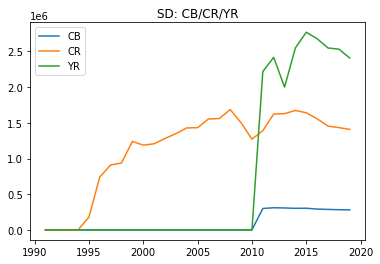

In [ ]:
f1, ax1 = plt.subplots()
ax1.plot(NTD_SD_Agg.index, NTD_SD_Agg['CB'], label='CB')
ax1.plot(NTD_SD_Agg.index, NTD_SD_Agg['CR'], label='CR')
ax1.plot(NTD_SD_Agg.index, NTD_SD_Agg['YR'], label='YR')
f1.show()
plt.legend()
plt.title('SD: CB/CR/YR')

#transpose_SD.plot(kind='line', y = 'CB')
#plt.xticks(transpose_SD.index)
#plt.figure(figsize=(30,30))

Text(0.5, 1.0, 'SD: LR')

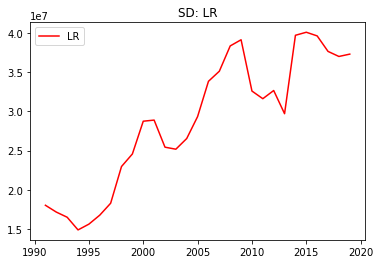

In [ ]:
f2, ax2 = plt.subplots()
ax2.plot(NTD_SD_Agg.index, NTD_SD_Agg['LR'], label='LR',color='red')
#plt.xticks(range(0,30,3))
f2.show()
plt.legend()
plt.title('SD: LR')

Text(0.5, 1.0, 'SD: MB')

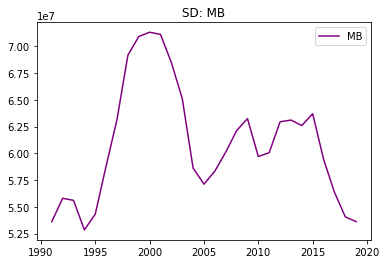

In [ ]:
f3, ax3 = plt.subplots()
ax3.plot(NTD_SD_Agg.index, NTD_SD_Agg['MB'], label='MB', color = 'purple')
#plt.xticks(range(0,30,3))
plt.legend()
f3.show()
plt.title('SD: MB')

---

__Analysis:__



For ```SD: MB```, we can clearly see that it gradually increses from 1991 to 2009,this is becase starting from 1991 to 2008, buses are increasing extensively due to the continuously constructed city sites, including corridors, convention centers, or hotels.[^1](https://www.sdmts.com/about/history) However, the great resession happened in 2008 and last about three years. This well explains the decreasing portion of our data from 2008-2011 since people had no need to ride the bus anymore due to job loss. After 2011, the amount of ridership recovered gradually.[^2](https://www.bls.gov/opub/mlr/2018/article/great-recession-great-recovery.htm#:~:text=In%202010%2C%20however%2C%20the%20U.S.,than%20that%20in%20November%202007)

## __Portland__

In [ ]:
#select the same transportation as San Diego's
transpose_po2 = NTD_PO_Agg[['CB','YR', 'LR', 'MB']]

Text(0.5, 1.0, 'PO: CR, YR')

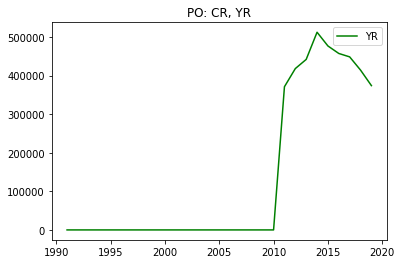

In [ ]:
f4, ax4 = plt.subplots()
ax4.plot(transpose_po2.index, transpose_po2['YR'], label='YR', color='green')
f4.show()
plt.legend()
plt.title('PO: CR, YR')

Text(0.5, 1.0, 'PO: CB')

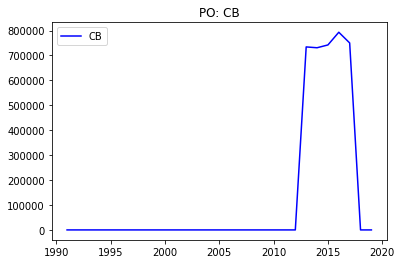

In [ ]:
f5, ax5 = plt.subplots()
ax5.plot(transpose_po2.index, transpose_po2['CB'], label='CB', color='blue')
f5.show()
plt.legend()
plt.title('PO: CB')

Text(0.5, 1.0, 'PO: LR')

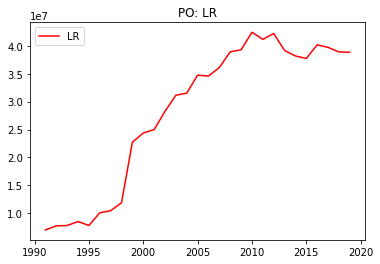

In [ ]:
f6, ax6 = plt.subplots()
ax6.plot(transpose_po2.index, transpose_po2['LR'], label='LR', color='red')
f6.show()
plt.legend()
plt.title('PO: LR')

Text(0.5, 1.0, 'PO: MB')

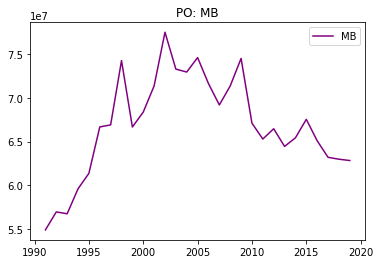

In [ ]:
f7, ax7 = plt.subplots()
ax7.plot(transpose_po2.index, transpose_po2['MB'], label='MB', color ='purple')
f7.show()
plt.legend()
plt.title('PO: MB')

---

__Analysis:__

For ```PO: LR```, notice the sudden increase in ridership, in the late 1990's. This increase can be explaind by the expansion of the Westside MAX, also known as the Blue Line that connects Portland to Hillsboro. [^1](https://en.wikipedia.org/wiki/TriMet)

For ```PO: MB```, the decrease in bus ridership from 2008 until the early 2010's was a consequence of the weakening of the economy and double digit unemployment accounts for the sharp decrease in bus ridership.[^2](https://www.oregonlive.com/commuting/2010/01/trimet_bus_ridership_plummets.html)Comparing Portland's chart with San Deigo, we can see the similarity in ridership decline during this time.

## __Sacramento__

In [ ]:
transpose_sa2 = NTD_SA_Agg.iloc[:,:-1]
transpose_sa2.head()

Mode,CB,LR,MB
1991,0.0,6592504.0,16776007.0
1992,0.0,6781165.0,16457967.0
1993,0.0,6571393.0,15090018.0
1994,0.0,6958332.0,16584790.0
1995,0.0,7063657.0,16665272.0


Text(0.5, 1.0, 'SA: CB')

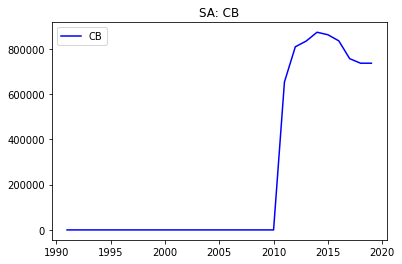

In [ ]:
f8, ax8 = plt.subplots()
ax8.plot(transpose_sa2.index, transpose_sa2['CB'], label='CB', color='blue')
f8.show()
plt.legend()
plt.title('SA: CB')

Text(0.5, 1.0, 'SA: LR')

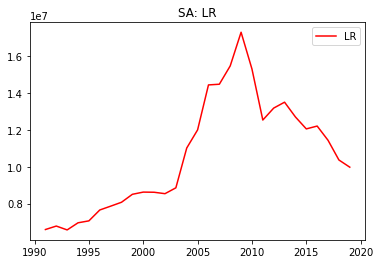

In [ ]:
f9, ax9 = plt.subplots()
ax9.plot(transpose_sa2.index, transpose_sa2['LR'], label='LR', color='red')
f9.show()
plt.legend()
plt.title('SA: LR')

Text(0.5, 1.0, 'SA: MB')

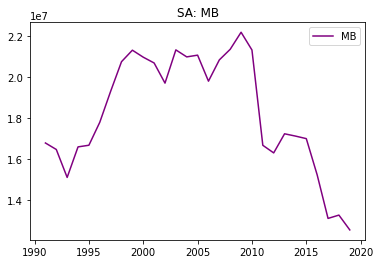

In [ ]:
f10, ax10 = plt.subplots()
ax10.plot(transpose_sa2.index, transpose_sa2['MB'], label='MB', color='purple')
f10.show()
plt.legend()
plt.title('SA: MB')

---

__Analysis:__

For ```SA: LR```, light rail transit ridership steadilly increased from the mid 1990's to 2003. Notice the dramatic increase in 2003. This was a consequence of the expansion of Sacramento's Regional Transit opening up the first phasee of Blue Line, formally known as the South Line.[^1](https://en.wikipedia.org/wiki/Sacramento_RT_Light_Rail)

For ```SA: MB```, similar to the bus development trend as San Diego, Sacramento has a general increasing trend due to the city construction. However, as the outbreak of the Great Depression, the bus ridership is severely affected economically. As the recovery of economy, the ridership gradually swings back to increase.

# Data Analysis & Results

In [ ]:
def create_regression_summary(ind_var_df, dep_var_df, ind_var_col, dep_var_col):
    # this function from open AI chat GPT
    # Concatenate the independent and dependent variable dataframes
    df = pd.concat([ind_var_df, dep_var_df], axis=1)

    # Create the regression formula string
    formula_str = f"{dep_var_col} ~ {ind_var_col}"

    # Fit a linear regression model using the formula
    model = smf.ols(formula=formula_str, data=df).fit()

    # Return the regression summary
    return model.summary()

In [ ]:
LR_MB_VRH_SD = create_regression_summary(SD_service_expansions, SD_VRH_Norm_per, 'LR_exp', 'MB')
LR_LR_VRH_SD = create_regression_summary(SD_service_expansions, SD_VRH_Norm_per, 'LR_exp', 'LR')
LR_MB_POP_SD = create_regression_summary(SD_service_expansions, SD_Pop_Norm_per, 'LR_exp', 'MB')
LR_LR_POP_SD = create_regression_summary(SD_service_expansions, SD_Pop_Norm_per, 'LR_exp', 'LR')
LR_MB_VRH_SA = create_regression_summary(SA_service_expansions, SA_VRH_Norm_per, 'LR_exp', 'MB')
LR_LR_VRH_SA = create_regression_summary(SA_service_expansions, SA_VRH_Norm_per, 'LR_exp', 'LR')
LR_MB_POP_SA = create_regression_summary(SA_service_expansions, SA_Pop_Norm_per, 'LR_exp', 'MB')
LR_LR_POP_SA = create_regression_summary(SA_service_expansions, SA_Pop_Norm_per, 'LR_exp', 'LR')
LR_MB_VRH_PDX = create_regression_summary(PDX_service_expansions, PDX_VRH_Norm_per, 'LR_exp', 'MB')
LR_LR_VRH_PDX = create_regression_summary(PDX_service_expansions, PDX_VRH_Norm_per, 'LR_exp', 'LR')
LR_MB_POP_PDX = create_regression_summary(PDX_service_expansions, PDX_Pop_Norm_per, 'LR_exp', 'MB')
LR_LR_POP_PDX = create_regression_summary(PDX_service_expansions, PDX_Pop_Norm_per, 'LR_exp', 'LR')

In [ ]:
list_of_summaries = [LR_MB_VRH_SD, LR_LR_VRH_SD, LR_MB_POP_SD, LR_LR_POP_SD, LR_MB_VRH_SA, LR_LR_VRH_SA, LR_MB_POP_SA, LR_LR_POP_SA, LR_MB_VRH_PDX, LR_LR_VRH_PDX, LR_MB_POP_PDX, LR_LR_POP_PDX]

In [ ]:
print(list_of_summaries)

[<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
Dep. Variable:                     MB   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.802
Date:                Fri, 09 Dec 2022   Prob (F-statistic):              0.191
Time:                        05:57:04   Log-Likelihood:                 48.365
No. Observations:                  29   AIC:                            -92.73
Df Residuals:                      27   BIC:                            -90.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Int

# Ethics & Privacy

We obtained most of our data from https://www.transit.dot.gov/ which is published by the government and open for people to use. The data only includes the usage of different types of transportations over years, which does not involve any individual’s privacy. Specifically, we used the U.S. census data which is already cleared for ethics. Additionally the datasets we used in our EDA processes were made by us using the data we've been working with. Our research question is well posed and not using any private information nor revealing private data of any individual or organization. Our analysis is transparent and designed to answer our research question. If any data or process in this project involves privacy issues, please contact us and we will remove related parts.

# Conclusion & Discussion

To do this analysis, we took year-over-year changes in ridership in Sacramento, Portland, and San Diego, normalized by Vehicle Revenue Hours (to try to tease out ridership per frequency) and by population (to try to tease out ridership per person in the service region). We then used linear regression to attempt to tease out the relationship between this normalized dataset and a hand-built record of new project openings, where a year in which a new project was marked with a 1 and other years marked with a 0. 

  Due to poor information on openings of new bus lines, commuter rail lines, etc., we only had enough data to look at Light rail openings and their effects on Motor Buses and Light Rail. In all three cities we looked at, we consistently found low R-squared values at or under 20%, and insignificant p-values at an alpha of 0.05. Only one p-value was significant, and because we ran 12 analyses, there is a too-high probability that this is due to random chance to consider the data valid. 

  It is possible that our failure to uncover a relationship between the opening of a new light rail and changes in ridership on light rail and bus networks is due to the lack of such relationship existing. However, it is also possible, and by intuition we believe it likely, that such a relationship actually exists, at least for the case of light rail expansions affecting light rail ridership. If we did fail to find a real relationship, our methodology is likely the reason. We counted any opening, no matter how large or small, as the same. Furthermore, it's common knowledge in transit planning that ridership often lags new projects due to the needs of legibility and public familiarity. It's also possible that the list of new projects we created by scraping press releases and news is incomplete, creating a garbage-in garbage-out scenario. 

# Team Contributions

- Hang Liu - Contribute on EDA, Data Cleaning, Ethic, and research section
- Alfonso's contribution is writing various summaries and analyses all throughout the project. I also did various research on the history of the various transportation methods in the three areas we focused on. Also helped with some of the code in the EDA section.
- Bobby and Mingjin’s contributions were to research all possible expansions of transit systems in San Diego, Portland, and Sacramento. We created the datasets that included each transit mode for each city and we used that to compare whether these expansions were relevant to increase in passenger ridership of commuter bus and lite rail systems. In the EDA section, Bobby and Mingjin conducted a shot analysis and interpretation of the findings of each city to infer whether this data would help support our hypothesis.
- Nathaniel: Research Question/Hypothesis, Code for Data Cleaning, EDA, and Final Analysis